In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130812 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [7]:
ls

144bandPng/              HSI_DATA.tif    s1.tif
HSI_AFTER_PCA_TEST.csv   LiDAR_DATA.tif  test.txt
HSI_AFTER_PCA_TRAIN.csv  PCA3Band/       train.txt


In [0]:
from osgeo import gdal
import numpy as np
from sklearn.decomposition import PCA
import cv2

In [0]:
raster = gdal.Open("LiDAR_DATA.tif")

data = np.array(raster.ReadAsArray())

In [11]:
cv2.imwrite("PCA3Band/3.png", data)

True

In [0]:
import cv2
for i in range(data.shape[0]):
  cv2.imwrite("144BandPng/" + str(i) + ".png", data[i])

In [0]:
NUM_BANDS = data.shape[0]
HEIGHT = data.shape[1]
WIDTH = data.shape[2]
hsi_data_2d = data.transpose(1, 2, 0).reshape((HEIGHT * WIDTH), NUM_BANDS)
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(hsi_data_2d)
principalComponents = np.array(principalComponents).transpose(1, 0).reshape(3, HEIGHT, WIDTH)

In [0]:
cv2.imwrite("PCA3Band/0.png", principalComponents[0])
cv2.imwrite("PCA3Band/1.png", principalComponents[1])
cv2.imwrite("PCA3Band/2.png", principalComponents[2])

True

In [0]:
from osgeo import gdal
raster = gdal.Open("s1.tif")


In [0]:
import numpy as np
arr = np.array(raster.ReadAsArray())
print(arr.shape)

(43, 19, 16)


In [0]:
arr = arr[0:13]

In [0]:
print(arr[0].shape)

(19, 16)


In [0]:
cd drive/Undergraduate_Project/

/content/drive/Undergraduate_Project


In [0]:
!ls

AverageAccuracy.py  deneme.ipynb       HSI_CNN.py    Models
baboon.png	    drive	       HSI_LiDAR     normalization.py
blank.png	    HoustonDataset     LiDAR_CNN.py  parameter.py
cengiz.py	    HoustonDataset.py  lidar.png     __pycache__
data		    HSI_CNN.ipynb      map.png


In [0]:
import numpy as np
import HoustonDataset
dataset = HoustonDataset.Houston()

hsi_data =  dataset.HSI_PCA(n_components=3)


In [0]:
pc1 = hsi_data[0]
pc2 = hsi_data[1]
pc3 = hsi_data[2]

In [0]:
pc1 = np.interp(pc1, (pc1.min(), pc1.max()), (0, 255)).astype(int)
pc2 = np.interp(pc2, (pc2.min(), pc2.max()), (0, 255)).astype(int)
pc3 = np.interp(pc3, (pc3.min(), pc3.max()), (0, 255)).astype(int)

In [0]:
import cv2
cv2.imwrite('hsi_pc2.png',pc3)

True

In [0]:
lidar_data =  dataset.get_lidar_data()

In [0]:
lidar = np.interp(lidar_data, (lidar_data.min(), lidar_data.max()), (0, 255)).astype(int)
import cv2
cv2.imwrite('lidar.png',lidar)

True

In [0]:
import numpy as np
import parameter
import HoustonDataset
import time
from datetime import timedelta
import math
from sklearn import metrics
import os
import normalization

In [0]:
def get_patches(data, pixels, patch_size):
    HEIGHT = data.shape[1]
    WIDTH = data.shape[2]
    offset = int(patch_size / 2)
    train_patches = []
    for i in range(HEIGHT):
        for j in range(WIDTH):
            if pixels[i][j] != 0:
                row_low = max(0, i - offset)
                row_high = min(HEIGHT - 1, i + offset)
                if row_low == 0:
                    row_high = row_low + patch_size - 1
                if row_high == HEIGHT - 1:
                    row_low = row_high - patch_size + 1

                col_low = max(0, j - offset)
                col_high = min(WIDTH - 1, j + offset)
                if col_low == 0:
                    col_high = col_low + patch_size - 1
                if col_high == WIDTH - 1:
                    col_low = col_high - patch_size + 1

                train_patches.append(data[0:, row_low:row_high + 1, col_low:col_high + 1])
    return np.array(train_patches)

In [0]:
HSI_PATCH_SIZE = 27
LiDAR_PATCH_SIZE = 41
KERNEL_SIZE = parameter.kernel_size
CONV1 = parameter.conv1
CONV2 = parameter.conv2
FC1 = parameter.fc1
FC2 = parameter.fc2
LEARNING_RATE = parameter.learning_rate

In [0]:
dataset = HoustonDataset.Houston()

#hsi_data = dataset.get_hsi_data()
hsi_data =  dataset.HSI_PCA(n_components=3)



train_pixels = dataset.get_train_pixels() 
test_pixels = dataset.get_test_pixels()


train_labels = dataset.get_train_labels()
test_labels = dataset.get_test_labels()


hsi_train_patches = get_patches(hsi_data, train_pixels, HSI_PATCH_SIZE)
hsi_test_patches = get_patches(hsi_data, test_pixels, HSI_PATCH_SIZE)




In [0]:
print(hsi_data.shape)
print(train_pixels.shape)
print(test_pixels.shape)
print(train_labels.shape)
print(test_labels.shape)
print(hsi_train_patches.shape)
print(hsi_test_patches.shape)

(3, 349, 1905)
(349, 1905)
(349, 1905)
(2832,)
(12197,)
(2832, 3, 27, 27)
(12197, 3, 27, 27)


In [0]:
import keras

train_one_hot = keras.utils.to_categorical(train_labels-1)
test_one_hot = keras.utils.to_categorical(test_labels-1)

NUM_CLS = train_one_hot.shape[1]

HSI_BANDS = hsi_train_patches.shape[1]


                                #(2832, 144, 27, 27)
hsi_train_img = np.array(hsi_train_patches.transpose(0,2,3,1).reshape(hsi_train_patches.shape[0], HSI_PATCH_SIZE, HSI_PATCH_SIZE, HSI_BANDS))
hsi_test_img = np.array(hsi_test_patches.transpose(0, 2, 3, 1).reshape(hsi_test_patches.shape[0], HSI_PATCH_SIZE, HSI_PATCH_SIZE, HSI_BANDS))

Using TensorFlow backend.


In [0]:
print(hsi_train_img.shape)
print(hsi_test_img.shape)

(2832, 27, 27, 3)
(12197, 27, 27, 3)


In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.layers import InputLayer
from tensorflow.python.keras.layers import  MaxPooling2D
from tensorflow.python.keras.layers import BatchNormalization, Dropout
from tensorflow.python.keras.optimizers import Adam,SGD

model = Sequential()
model.add(InputLayer(input_shape=(HSI_PATCH_SIZE, HSI_PATCH_SIZE, HSI_BANDS)))
model.add(Conv2D(kernel_size=3, strides=1, filters=CONV1, padding='same', activation='relu', name='conv1'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(kernel_size=5, strides=1, filters=CONV2, padding='same', activation='relu', name='conv2'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))


model.add(Flatten())
model.add(Dense(FC1, activation='relu'))
model.add(Dropout(0.75))
model.add(Dense(FC2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLS, activation='softmax'))

sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


history = model.fit(hsi_train_img, train_one_hot, batch_size=25, shuffle=True, epochs=240)

Epoch 1/240
2832/2832 [==============================] - 8s 3ms/step - loss: 3.6474 - acc: 0.2454
Epoch 2/240
2832/2832 [==============================] - 4s 1ms/step - loss: 1.8336 - acc: 0.4121
Epoch 3/240
2832/2832 [==============================] - 4s 1ms/step - loss: 1.3815 - acc: 0.5565
Epoch 4/240
2832/2832 [==============================] - 4s 1ms/step - loss: 1.1069 - acc: 0.6306
Epoch 5/240
2832/2832 [==============================] - 4s 1ms/step - loss: 0.9326 - acc: 0.6787
Epoch 6/240
2832/2832 [==============================] - 4s 1ms/step - loss: 0.8211 - acc: 0.7179
Epoch 7/240
2832/2832 [==============================] - 4s 1ms/step - loss: 0.6928 - acc: 0.7758
Epoch 8/240
2832/2832 [==============================] - 4s 1ms/step - loss: 0.6493 - acc: 0.7878
Epoch 9/240
2832/2832 [==============================] - 4s 1ms/step - loss: 0.6014 - acc: 0.8097
Epoch 10/240
2832/2832 [==============================] - 4s 1ms/step - loss: 0.5624 - acc: 0.8206
Epoch 11/240
2832/2

In [0]:
train_cls = dataset.get_train_labels() - 1
prediction = model.predict(hsi_train_img).argmax(axis=-1)



from sklearn import metrics, preprocessing
from AverageAccuracy import AA_andEachClassAccuracy

overall_acc = metrics.accuracy_score(prediction, train_cls)
kappa = metrics.cohen_kappa_score(prediction, train_cls)
confusion_matrix = metrics.confusion_matrix(prediction, train_cls)
each_acc, average_acc = AA_andEachClassAccuracy(confusion_matrix) 


print("Overall Accuracy of training sapmles : ",overall_acc)
print("Average Accuracy of training samples : ",average_acc)
print("Kappa statistics of training samples : ",kappa)
print("Each class accuracy of training samples : ", each_acc)
print("Confusion matrix :", confusion_matrix)



Overall Accuracy of training sapmles :  0.998587570621469
Average Accuracy of training samples :  0.9986324786324786
Kappa statistics of training samples :  0.9984866050923707
Each class accuracy of training samples :  [1.         1.         1.         1.         1.         1.
 1.         0.97948718 1.         1.         1.         1.
 1.         1.         1.        ]
Confusion matrix : [[198   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 190   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 192   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 188   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 186   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0 182   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 196   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 191   0   0   0   4   0   0   0]
 [  0   0   0   0   0   0   0   0 193   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 191 

In [0]:
#hsi_test_img = hsi_test_patches.transpose(0,2,3,1).reshape(hsi_test_patches.shape[0], HSI_PATCH_SIZE, HSI_PATCH_SIZE, HSI_BANDS)

test_cls = dataset.get_test_labels() - 1
prediction = model.predict(hsi_test_img).argmax(axis=-1)



from sklearn import metrics, preprocessing
from AverageAccuracy import AA_andEachClassAccuracy

overall_acc = metrics.accuracy_score(prediction, test_cls)
kappa = metrics.cohen_kappa_score(prediction, test_cls)
confusion_matrix = metrics.confusion_matrix(prediction, test_cls)
each_acc, average_acc = AA_andEachClassAccuracy(confusion_matrix) 


print("Overall Accuracy of testing sapmles : ",overall_acc)
print("Average Accuracy of testing samples : ",average_acc)
print("Kappa statistics of testing samples : ",kappa)
print("Each class accuracy of testing samples : ", each_acc)
print("Confusion matrix :", confusion_matrix)


Overall Accuracy of testing sapmles :  0.7105025826022793
Average Accuracy of testing samples :  0.7631304113768933
Kappa statistics of testing samples :  0.6863396388905167
Each class accuracy of testing samples :  [0.86792453 0.98391421 0.18059299 0.94016227 0.81124807 0.77922078
 0.93515704 0.4511041  0.92921348 0.72572402 0.77941176 0.52990354
 0.91532258 0.88979592 0.72826087]
Confusion matrix : [[ 828   90    0   35    0    0    0    0    0    0    0    0    0    0
     1]
 [  11  734    0    1    0    0    0    0    0    0    0    0    0    0
     0]
 [ 178  158  268   70    0   17   80  173   14  328  129    5   20    0
    44]
 [   9    9    0  927    0    0   16    0   25    0    0    0    0    0
     0]
 [   0    0   22    0 1053    0    0   19    1    0    0    1    0    0
   202]
 [  19    0    3    5    0  120    0    0    0    0    4    3    0    0
     0]
 [   4   12   19    8    0    0  923   11    0    0    0    0   10    0
     0]
 [   3   44   15    6    3    0   19

In [0]:
model.save_weights('Models/hsi_model_weights.h5')


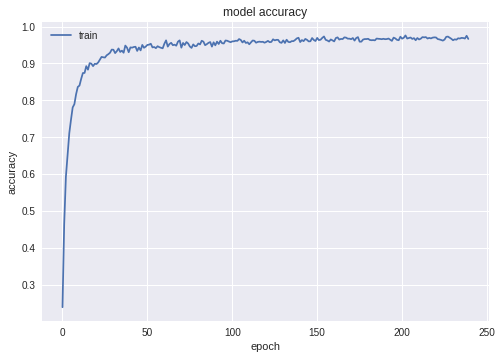

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

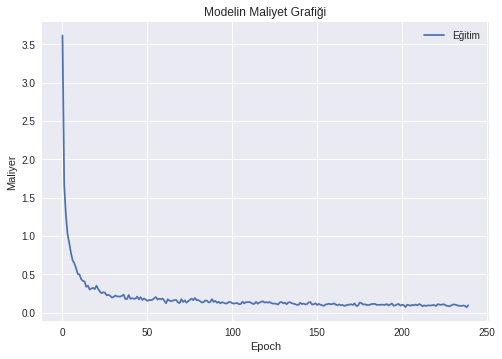

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('Modelin Maliyet Grafiği')
plt.ylabel('Maliyer')
plt.xlabel('Epoch')
plt.legend(['Eğitim'], loc='upper right')
plt.show()